<a href="https://colab.research.google.com/github/ElizabethGhi/tools-for-remote-sensing-data-analysis/blob/main/Soil_Properties_Download_Datasets_nc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade xee

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.0 MB/s eta 0:00:00


In [2]:
!pip install --upgrade geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00


In [3]:
!pip install --upgrade netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.2 MB/s eta 0:00:00


In [5]:
import ee
import os
import geemap
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [11]:
geemap.ee_initialize(project='ee-xxxxxxxxxxxx')
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com', project='ee-xxxxxxxxxxxxx')

In [44]:
#LEER .nc DEL AREA DE ESTUDIO
path = "/gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis"
area_estudio = xr.open_dataset(os.path.join(path, "NetCDF_CM/Poligonos_int.nc"))

In [41]:
#Leer propiedades del suelo (6 niveles de profundidad (b0=0, b0=10, b30=30, b60=60, b100=100 y b200=200 cm)
geometry = ee.Geometry.BBox(-99.466, 19, -98.133, 20.233) #lon,lat del area rectangular que abarca el area de estudio
sand = ee.Image("OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02")   #Contenido de arena en % (kg / kg)
clay=ee.Image ("OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02")    #Contenido de arcilla en % (kg / kg)
orgc=ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")       #Contenido de carbono orgánico del suelo en x 5 g / kg

#Conertir a xarray
sand_xr = xr.open_dataset(sand, engine='ee', geometry=geometry, scale=0.001)
clay_xr = xr.open_dataset(clay, engine='ee', geometry=geometry, scale=0.001)
orgc_xr = xr.open_dataset(orgc, engine='ee', geometry=geometry, scale=0.001)

#Recortar al area de estudio
mascara_cm = area_estudio['CM']
mascara_cm_sand = mascara_cm.interp_like(sand_xr, method='nearest')
mascara_cm_clay = mascara_cm.interp_like(clay_xr, method='nearest')
mascara_cm_orgc = mascara_cm.interp_like(orgc_xr, method='nearest')

#Multiplicar por los factores de escala y obtener fracciones
sand_cm = (sand_xr.where(mascara_cm_sand == 1))*(0.01)
clay_cm = (clay_xr.where(mascara_cm_clay == 1))*(0.01)
orgc_cm = (orgc_xr.where(mascara_cm_orgc == 1))*(5 * 0.001)

In [45]:
orgc_cm

<xarray.Dataset> Size: 39MB
Dimensions:  (time: 1, lon: 1333, lat: 1233)
Coordinates:
  * time     (time) datetime64[ns] 8B 1950-01-01
  * lon      (lon) float64 11kB -99.47 -99.46 -99.46 ... -98.14 -98.13 -98.13
  * lat      (lat) float64 10kB 19.0 19.0 19.0 19.0 ... 20.23 20.23 20.23 20.23
Data variables:
    b0       (time, lon, lat) float32 7MB nan nan nan nan ... nan nan nan nan
    b10      (time, lon, lat) float32 7MB nan nan nan nan ... nan nan nan nan
    b30      (time, lon, lat) float32 7MB nan nan nan nan ... nan nan nan nan
    b60      (time, lon, lat) float32 7MB nan nan nan nan ... nan nan nan nan
    b100     (time, lon, lat) float32 7MB nan nan nan nan ... nan nan nan nan
    b200     (time, lon, lat) float32 7MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG:4326

In [46]:
#Exportar datasets
sand_cm.to_netcdf(os.path.join(path, "NetCDF_CM/sand_fraction.nc"))
clay_cm.to_netcdf(os.path.join(path, "NetCDF_CM/clay_fraction.nc"))
orgc_cm.to_netcdf(os.path.join(path, "NetCDF_CM/orgc_fraction.nc"))


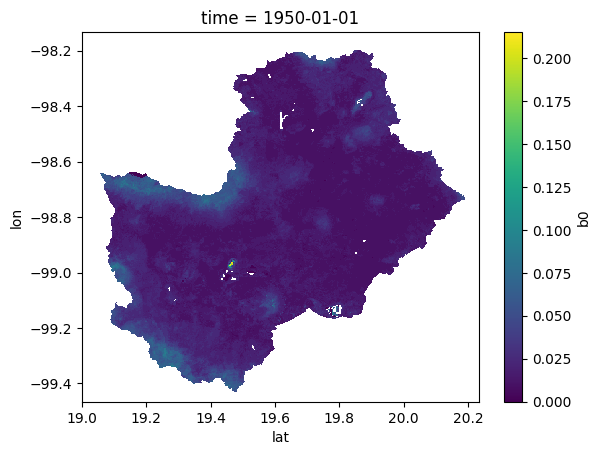

In [47]:
#Visualizar la banda "b0" de sand_cm
sand_b0 = orgc_cm["b0"].squeeze()
sand_b0.plot.imshow(cmap="viridis")
plt.show()